In [1]:
import numpy as np
import os
import glob
import topofisher
from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer
from topofisher.filtrations.numpy.default_filtrations import AlphaFiltration
from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
import matplotlib.pyplot as plt
from topofisher.fisher.Fisher import show_fm_and_bias, fisherMOPED, fisherFromVecs
import tensorflow as tf
import importlib
importlib.reload(topofisher.fisher.imnn)
from topofisher.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer
import pickle, glob

2023-11-01 15:17:53.036451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 15:17:57.385441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Functions, benchmarks and familiarizing with data

## Some functions

In [2]:
def shuffle_along_axis(arr, seed):
    # Create a random number generator with the specified seed
    rng = np.random.RandomState(seed)

    # Use the random number generator to shuffle the array along the first axis
    shuffled_arr = arr[rng.permutation(arr.shape[0])]
    return shuffled_arr

def get_vecs(directory_path):
    # Find all pickle files in the directory
    pickle_files = glob.glob(os.path.join(directory_path, '*.pkl'))
    fid_vecs = []
    der_vecs = {}
    param_list = ["Om_m", "Om_p", "s8_m", "s8_p"]
    for item in param_list : der_vecs[item] = []
    # print(pickle_files)
    for file_path in pickle_files:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            fid_vecs.append(data[0]['fiducial'])
            # print(data[0].keys())
            for item in param_list : der_vecs[item].append(data[1][item])

    fid_arr = np.array(np.concatenate(fid_vecs, axis = 0), dtype = np.float64)
    # der_arr = np.array([ for item in param_list], dtype = np.float64)
    der_arr = {}
    for item in param_list: der_arr[item] = np.array(np.concatenate(der_vecs[item], axis = 0), dtype = np.float64)
    return [fid_arr, der_arr['Om_m'], der_arr['Om_p'], der_arr['s8_m'], der_arr['s8_p']]


def fisherAnalysisMOPED(directory_path):
    # Find all pickle files in the directory
    arrs = get_vecs(directory_path)
    seeds = [np.random.randint(100) for _ in range(3)]
    fid_arr = shuffle_along_axis(arrs[0], seed = seeds[0])
    der_arr = [shuffle_along_axis(arrs[idx + 1], seeds[idx//2 + 1]) for idx in range(4)]
    fish = fisherMOPED([fid_arr, *der_arr], np.array([0.02, 0.03]))
    show_fm_and_bias(fish)
    return fish

def fisherAnalysis(directory_path):
    # Find all pickle files in the directory
    arrs = get_vecs(directory_path)
    seeds = [np.random.randint(100) for _ in range(3)]
    # fid_arr, der_arr = arrs[0], arrs[1:]
    fid_arr = shuffle_along_axis(arrs[0], seed = seeds[0])
    der_arr = [shuffle_along_axis(arrs[idx + 1], seeds[idx//2 + 1]) for idx in range(4)]
    fish = fisherFromVecs([fid_arr, *der_arr], np.array([0.02, 0.03]))
    show_fm_and_bias(fish)
    return fish

In [3]:
def plotLearningGraphs(history):
    ncols = 4
    fig, axes = plt.subplots(nrows=1, ncols= ncols, figsize=(3 * ncols + 2 , 3))
    lis = ['loss', 'lnfi', 'bias0', 'bias1']
    for idx in range(4) :
        axes[idx].plot(history[lis[idx]][1:], label = "Training")
        axes[idx].plot(history['val_' + lis[idx]][1:], label = "Validation")
        if "bias" in lis[idx]: axes[idx].axhline(0.2, linestyle = 'dotted', c = 'black')
        axes[idx].set_title(lis[idx])
    fig.legend(labels=['Training', 'Validation']) 
   

## Benchmark from Jacky

In [239]:
mat = [[175536.25526324,  175715.25139639], [175715.25139638, 637509.6239556]]
print ("log FI = ", np.log(np.linalg.det(mat)))
print ("FM = ", np.round(np.array(mat).flatten(), 2))
print("Constraints = ", np.sqrt(np.diag(np.linalg.inv(mat))))

log FI =  25.11808779261557
FM =  [175536.26 175715.25 175715.25 637509.62]
Constraints =  [0.00280492 0.00147184]


## Shady things about the derivatives

log FI =  21.98
FM =  [158927.2   68534.29  68534.29  51693.79]
Fractional bias =  [5.79 6.3 ]
Constraints =  [0.00383296 0.00672069]


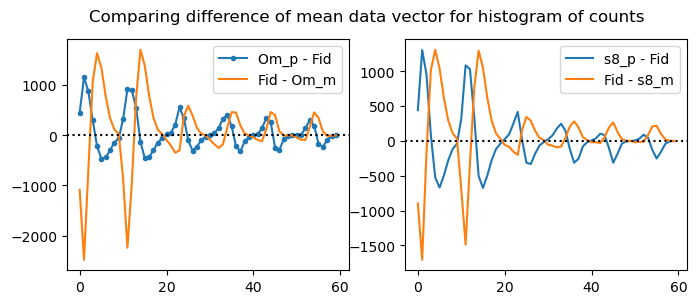

In [244]:
fish = fisherAnalysis('/Users/karthikviswanathan/Downloads/histogram_15_10')
zz = np.array([np.array(item).mean(axis = 0) for item in fish.summaries])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                             figsize=(3 * ncols + 2 , 3))
axes[0].plot(zz[2] - zz[0], label = "Om_p - Fid", marker = '.')
axes[0].plot(zz[0] - zz[1], label = "Fid - Om_m")
axes[0].axhline(0, c = 'black', linestyle = 'dotted')
axes[0].legend()

axes[1].plot(zz[4] - zz[0], label = "s8_p - Fid")
axes[1].plot(zz[0] - zz[3], label = "Fid - s8_m")

axes[1].axhline(0, c = 'black', linestyle = 'dotted')
axes[1].legend()

fig.suptitle("Comparing difference of mean data vector for histogram of counts")
plt.show()

log FI =  21.98
FM =  [158927.2   68534.29  68534.29  51693.79]
Fractional bias =  [5.77 6.28]
Constraints =  [0.00383296 0.00672069]


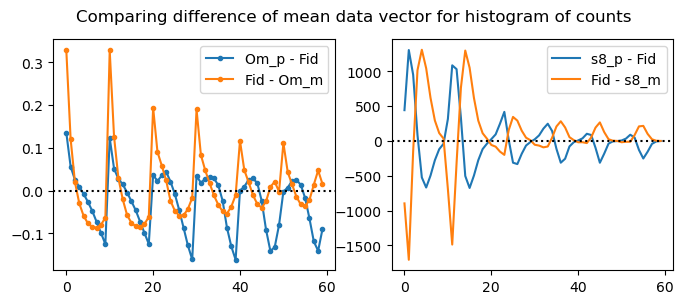

In [247]:
fish = fisherAnalysis('/Users/karthikviswanathan/Downloads/histogram_15_10')
zz = np.array([np.array(item).mean(axis = 0) for item in fish.summaries])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                             figsize=(3 * ncols + 2 , 3))
axes[0].plot((zz[2] - zz[0])/zz[0], label = "Om_p - Fid", marker = '.')
axes[0].plot(-(zz[0] - zz[1])/zz[0], label = "Fid - Om_m", marker = '.')
axes[0].axhline(0, c = 'black', linestyle = 'dotted')
axes[0].legend()

axes[1].plot(zz[4] - zz[0], label = "s8_p - Fid")
axes[1].plot(zz[0] - zz[3], label = "Fid - s8_m")

axes[1].axhline(0, c = 'black', linestyle = 'dotted')
axes[1].legend()

fig.suptitle("Comparing difference of mean data vector for histogram of counts")
plt.show()

In [215]:
fish.ders.shape

TensorShape([2, 60])

log FI =  21.98
FM =  [158927.2   68534.29  68534.29  51693.79]
Fractional bias =  [5.79 6.3 ]
Constraints =  [0.00383296 0.00672069]


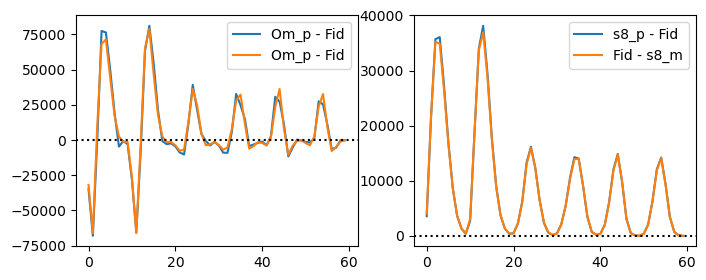

In [229]:
fish = fisherAnalysis('/Users/karthikviswanathan/Downloads/histogram_15_10')
ind = np.random.randint(100)
zz = np.array([np.array(item)[ind + np.random.randint(1)] for item in fish.summaries[1:]])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                             figsize=(3 * ncols + 2 , 3))
axes[0].plot((zz[1] - zz[0])/0.02, label = "Om_p - Fid")
axes[0].plot(fish.ders[0], label = "Om_p - Fid")
# axes[0].plot(zz[0], label = "Fid - Om_m")
axes[0].axhline(0, c = 'black', linestyle = 'dotted')
axes[0].legend()

axes[1].plot(zz[3] , label = "s8_p - Fid")
axes[1].plot(zz[2], label = "Fid - s8_m")

axes[1].axhline(0, c = 'black', linestyle = 'dotted')
axes[1].legend()

plt.show()

In [ ]:
zz[4]

log FI =  22.13
FM =  [159860.75  59861.15  59861.15  47856.18]
Fractional bias =  [63.   72.58]
Constraints =  [0.00343031 0.00626954]


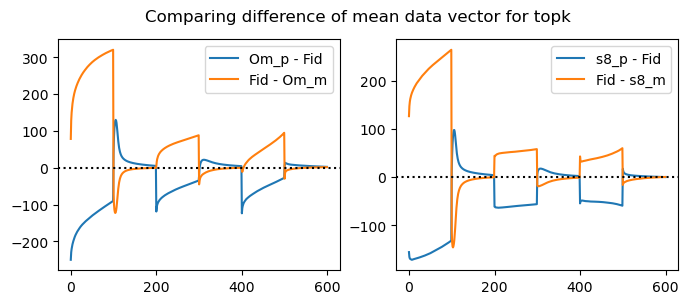

In [205]:
fish = fisherAnalysis('/Users/karthikviswanathan/Downloads/topk_15_100')
zz = np.array([np.array(item).mean(axis = 0) for item in fish.summaries])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                             figsize=(3 * ncols + 2 , 3))
axes[0].plot(zz[2] - zz[0], label = "Om_p - Fid")
axes[0].plot(zz[0] - zz[1], label = "Fid - Om_m")
axes[0].axhline(0, c = 'black', linestyle = 'dotted')
axes[0].legend()

axes[1].plot(zz[4] - zz[0], label = "s8_p - Fid")
axes[1].plot(zz[0] - zz[3], label = "Fid - s8_m")

axes[1].axhline(0, c = 'black', linestyle = 'dotted')
axes[1].legend()
fig.suptitle("Comparing difference of mean data vector for topk")
plt.show()

log FI =  22.13
FM =  [159860.75  59861.15  59861.15  47856.18]
Fractional bias =  [62.95 72.53]
Constraints =  [0.00343031 0.00626954]


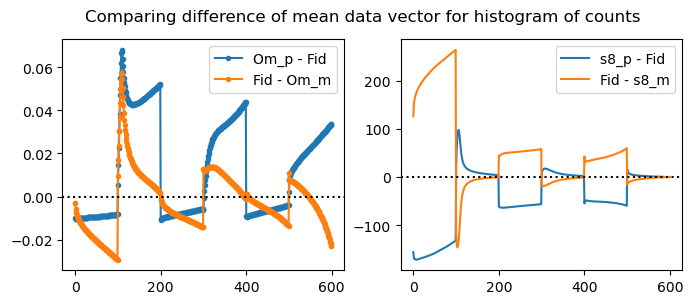

In [248]:
fish = fisherAnalysis('/Users/karthikviswanathan/Downloads/topk_15_100')
zz = np.array([np.array(item).mean(axis = 0) for item in fish.summaries])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                             figsize=(3 * ncols + 2 , 3))
axes[0].plot((zz[2] - zz[0])/zz[0], label = "Om_p - Fid", marker = '.')
axes[0].plot(-(zz[0] - zz[1])/zz[0], label = "Fid - Om_m", marker = '.')
axes[0].axhline(0, c = 'black', linestyle = 'dotted')
axes[0].legend()

axes[1].plot(zz[4] - zz[0], label = "s8_p - Fid")
axes[1].plot(zz[0] - zz[3], label = "Fid - s8_m")

axes[1].axhline(0, c = 'black', linestyle = 'dotted')
axes[1].legend()

fig.suptitle("Comparing difference of mean data vector for histogram of counts")
plt.show()

# Histogram

## 15

In [253]:
directory_path = '/Users/karthikviswanathan/Downloads/histogram_15_10'
vecs = get_vecs(directory_path)

In [175]:
directory_path = '/Users/karthikviswanathan/Downloads/histogram_15_10'
fish = fisherAnalysis(directory_path)
print("\nAfter MOPED")
fish = fisherAnalysisMOPED(directory_path)

log FI =  21.98
FM =  [158927.2   68534.29  68534.29  51693.79]
Fractional bias =  [5.77 6.29]
Constraints =  [0.00383296 0.00672069]

After MOPED
log FI =  21.96
FM =  [156447.22  67315.66  67315.66  50889.92]
Fractional bias =  [0.08 0.09]
Constraints =  [0.00385174 0.00675344]


'\nplt.hist(vecs[1][:,0], alpha = 0.7)\n\nplt.hist(vecs[2][:,0], alpha = 0.7)\n\nplt.hist(vecs[3][:,0], alpha = 0.7)\n\nplt.hist(vecs[4][:,0], alpha = 0.7)\n'

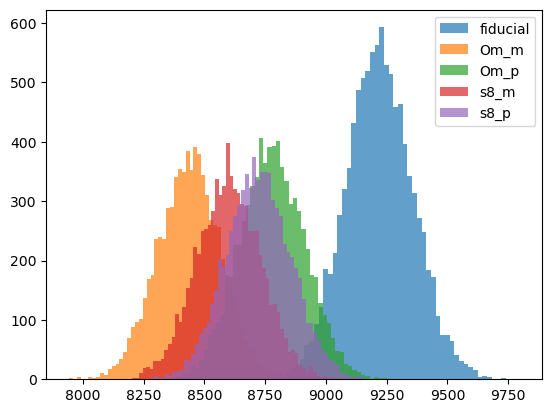

In [276]:

all_param_list = ["fiducial", "Om_m", "Om_p", "s8_m", "s8_p"]
for idx in range(5):
    plt.hist(vecs[idx][:,6], alpha = 0.7, label = all_param_list[idx], bins = 60)
plt.legend()
"""
plt.hist(vecs[1][:,0], alpha = 0.7)

plt.hist(vecs[2][:,0], alpha = 0.7)

plt.hist(vecs[3][:,0], alpha = 0.7)

plt.hist(vecs[4][:,0], alpha = 0.7)
"""

### IMNN

log FI =  21.9
FM =  [153720.97  67984.4   67984.38  51089.01]
Fractional bias =  [0.07 0.08]
Constraints =  [0.00397609 0.00689699]


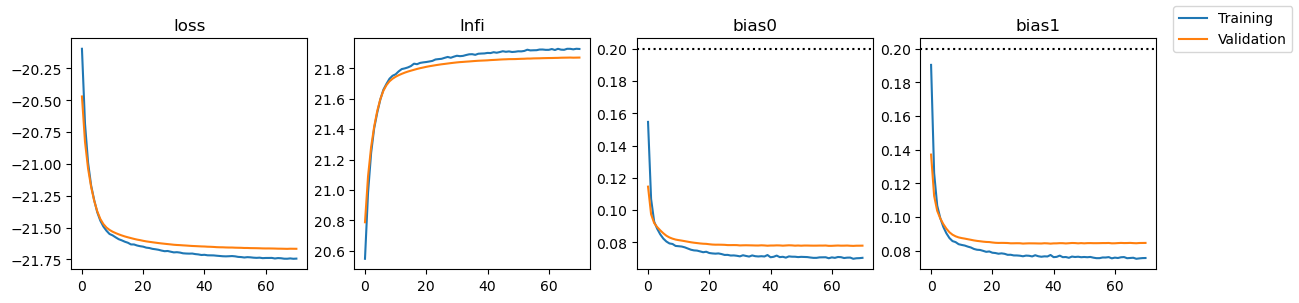

In [137]:
vecs = get_vecs(directory_path)
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 200, reg = tf.constant([1., 1.5]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)
 

log FI =  24.42
FM =  [1310660.    266945.1   266945.12   85118.74]
Fractional bias =  [0.13 0.18]
Constraints =  [0.00145328 0.00570271]


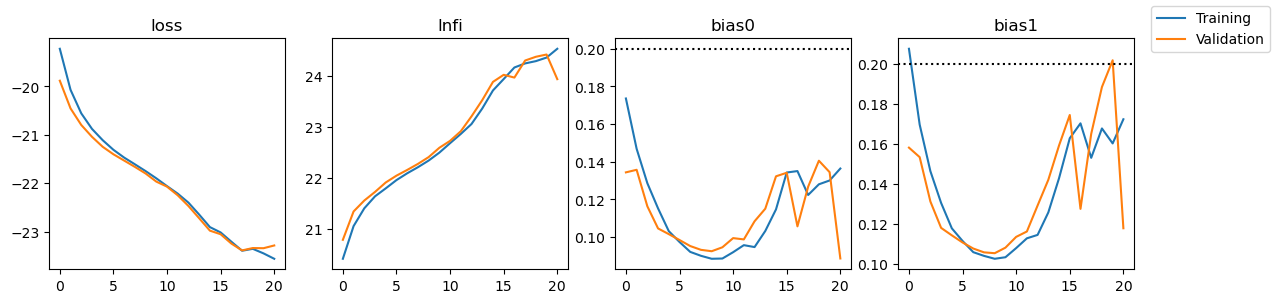

In [127]:
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu'),
    # tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 400, reg = 2*tf.constant([1., 2.]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3),
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)

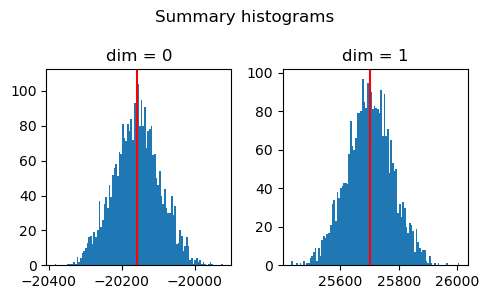

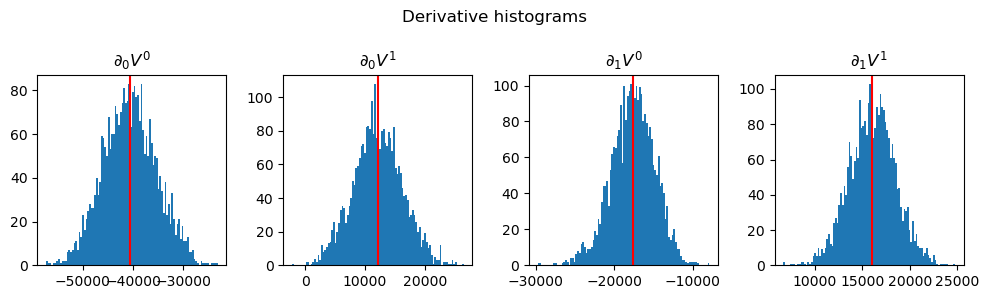

In [128]:
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists
plotSummaryDerivativeHists(fish)

In [142]:
np.cov(fish.summaries[1].numpy().T), np.cov(fish.summaries[0].numpy().T), np.cov(fish.summaries[2].numpy().T)

(array([[100590.66875483,  22315.0063849 ],
        [ 22315.0063849 ,  12178.53934204]]),
 array([[107818.06240346,  25219.95100821],
        [ 25219.95100821,  13095.0011652 ]]),
 array([[93911.58417261, 21078.91597734],
        [21078.91597734, 12024.38837836]]))

## 100

In [14]:
directory_path = '/Users/karthikviswanathan/Downloads/histogram_100_10'
fish = fisherAnalysis(directory_path)
print("After MOPED")
fish = fisherAnalysisMOPED(directory_path)

log FI =  19.85
FM =  [84139.32 22639.8  22639.8  11079.37]
Fractional bias =  [15.54 21.32]
Constraints =  [0.00513823 0.01415976]
After MOPED
log FI =  19.77
FM =  [78803.69 21588.55 21588.55 10807.3 ]
Fractional bias =  [0.22 0.3 ]
Constraints =  [0.00529415 0.01429587]


### IMNN

log FI =  19.69
FM =  [80137.71 20990.74 20990.74  9955.22]
Fractional bias =  [0.14 0.19]
Constraints =  [0.00527939 0.01497879]


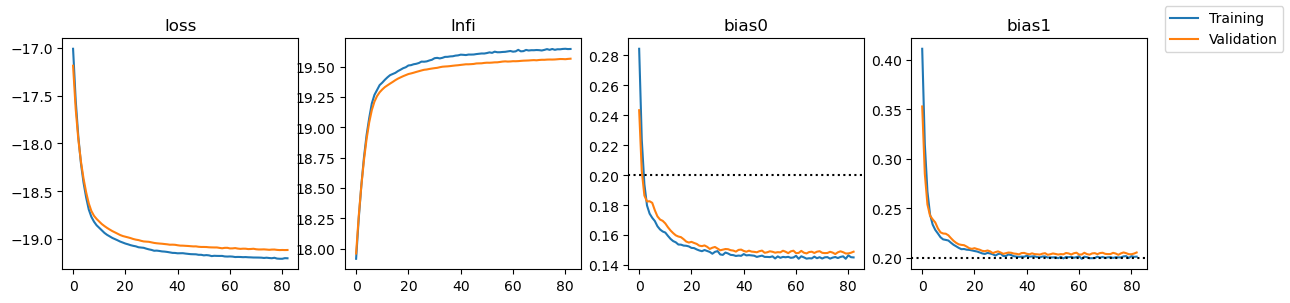

In [22]:
vecs = get_vecs(directory_path)
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 200, reg = tf.constant([1., 1.5]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)

## 15 + 100

In [249]:
directory_paths = ['/Users/karthikviswanathan/Downloads/histogram_15_10', \
                   '/Users/karthikviswanathan/Downloads/histogram_100_10']
v1, v2 = get_vecs('/Users/karthikviswanathan/Downloads/histogram_15_10'), \
            get_vecs('/Users/karthikviswanathan/Downloads/histogram_100_10')
vecs = [np.concatenate([va, vb], axis = -1) for va, vb in zip(v1, v2)]

In [252]:
fish = fisherFromVecs(vecs, np.array([0.02, 0.03]))
show_fm_and_bias(fish)

print("\nAfter compressing")
fish = fisherMOPED(vecs, np.array([0.02, 0.03]))
show_fm_and_bias(fish)

log FI =  22.09
FM =  [167198.98  71758.7   71758.7   54185.61]
Fractional bias =  [10.92 11.9 ]
Constraints =  [0.00372244 0.00653887]

After compressing
log FI =  22.01
FM =  [164206.23  70258.62  70258.62  52198.96]
Fractional bias =  [0.08 0.09]
Constraints =  [0.00378941 0.00672102]


log FI =  24.04
FM =  [963918.   204548.86 204548.86  71902.01]
Fractional bias =  [0.11 0.15]
Constraints =  [0.00161794 0.00592395]


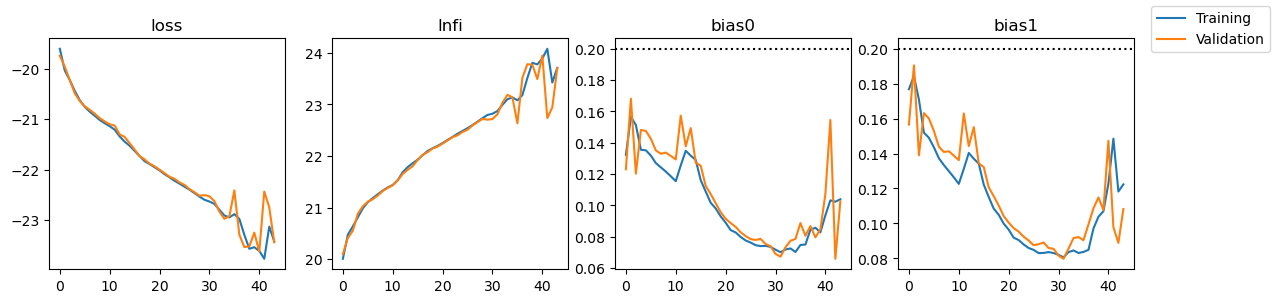

In [59]:
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation= tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 400, reg = tf.constant([1., 1.5]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       optimizer = tf.keras.optimizers.Adam(learning_rate= 5e-3),
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)

log FI =  20.16
FM =  [102049.73  34055.29  34055.29  16955.24]
Fractional bias =  [0.16 0.19]
Constraints =  [0.00545153 0.01337434]


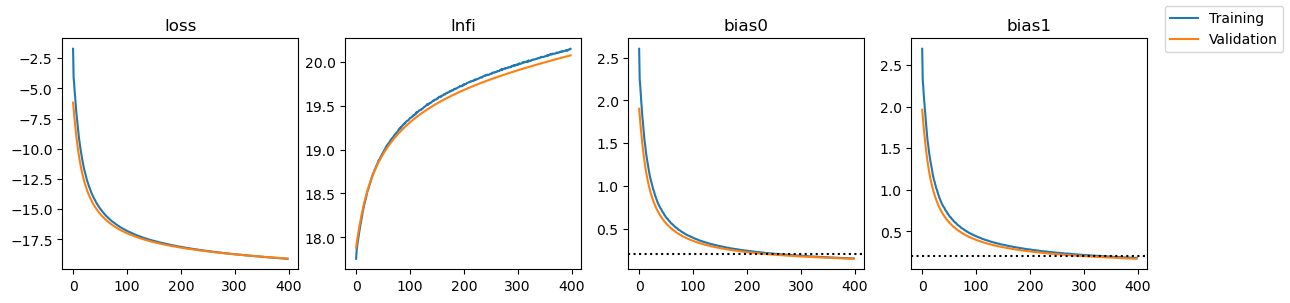

In [115]:
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 400, reg = 2*tf.constant([1., 2.]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       optimizer = tf.keras.optimizers.Adam(learning_rate= 5e-3),
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)

log FI =  23.35
FM =  [464809.62 -24401.8  -24401.78  30939.25]
Fractional bias =  [0.03 0.14]
Constraints =  [0.00149811 0.00580668]


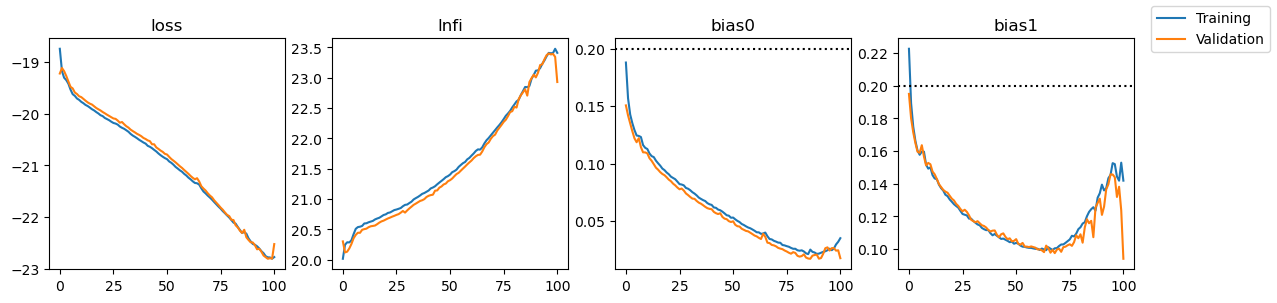

In [117]:
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation= 'relu'),
    # tf.keras.layers.Dense(10, activation= 'relu'),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 400, reg = 2*tf.constant([1., 2.]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       optimizer = tf.keras.optimizers.Adam(learning_rate= 5e-3),
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)

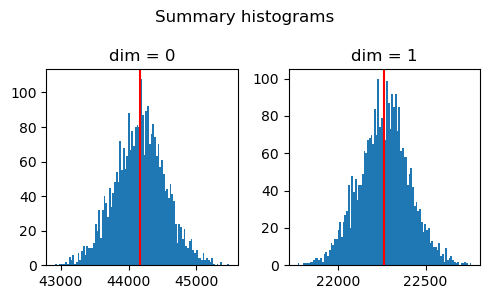

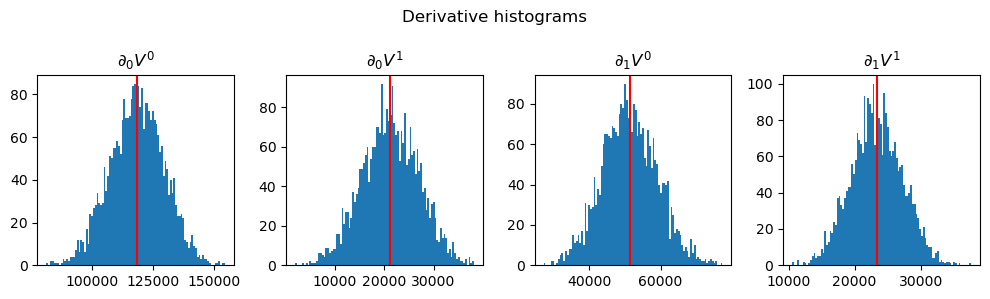

In [118]:
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists
plotSummaryDerivativeHists(fish)

# TopK

## k = 15

### 100 bins

In [24]:
directory_path = '/Users/karthikviswanathan/Downloads/topk_15_100'
fish = fisherAnalysis(directory_path)
print("After MOPED")
fish = fisherAnalysisMOPED(directory_path)

log FI =  22.13
FM =  [159860.75  59861.15  59861.15  47856.18]
Fractional bias =  [63.02 72.59]
Constraints =  [0.00343031 0.00626954]
After MOPED
log FI =  21.69
FM =  [128888.97  48626.2   48626.2   38715.31]
Fractional bias =  [0.1  0.12]
Constraints =  [0.00384006 0.00700655]


#### IMNN

log FI =  21.67
FM =  [117475.58  41688.46  41688.42  36779.32]
Fractional bias =  [0.06 0.07]
Constraints =  [0.00377364 0.00674424]


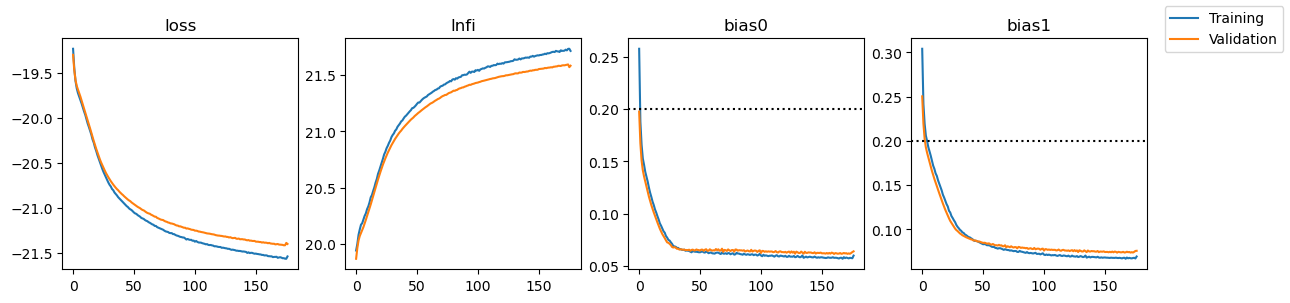

In [28]:
vecs = get_vecs(directory_path)
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
# all_vecs = all_vecs[:, : ,::2] + all_vecs[:, : ,1::2]
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation= tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 400, reg = tf.constant([1., 1.5]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       optimizer = tf.keras.optimizers.Adam(learning_rate= 5e-3),
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)

### 200 bins

In [30]:
directory_path = '/Users/karthikviswanathan/Downloads/topk_15_200'
fish = fisherAnalysis(directory_path)
fish = fisherAnalysisMOPED(directory_path)

log FI =  22.27
FM =  [171182.82  63860.13  63860.13  51333.71]
Fractional bias =  [126.07 145.39]
Constraints =  [0.00330158 0.00602907]
log FI =  21.37
FM =  [115327.02  43860.65  43860.65  33314.6 ]
Fractional bias =  [0.15 0.17]
Constraints =  [0.00416732 0.00775363]


#### IMNN

log FI =  21.8
FM =  [125674.77  44740.04  44740.04  39223.48]
Fractional bias =  [0.06 0.07]
Constraints =  [0.00366022 0.00655177]


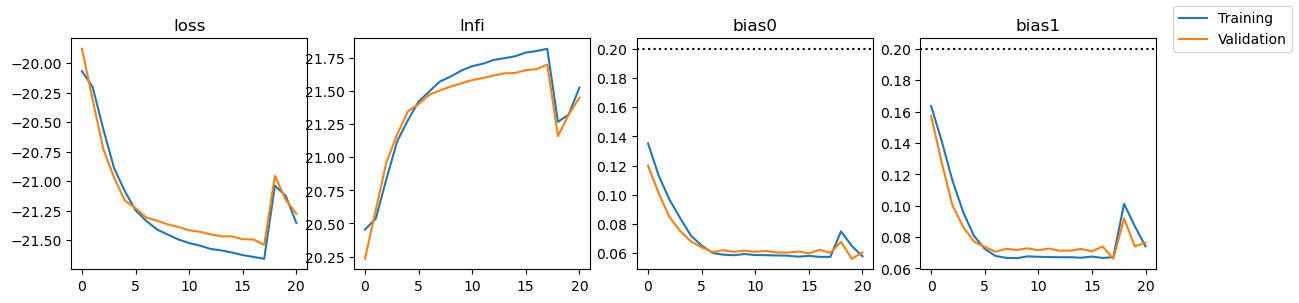

In [31]:
vecs = get_vecs(directory_path)
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
# all_vecs = all_vecs[:, : ,::2] + all_vecs[:, : ,1::2]
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation= tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 400, reg = tf.constant([1., 1.5]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       optimizer = tf.keras.optimizers.Adam(learning_rate= 5e-3),
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)

## k = 100

### 100 bins

In [32]:
directory_path = '/Users/karthikviswanathan/Downloads/topk_100_100'
fish = fisherAnalysis(directory_path)
fish = fisherAnalysisMOPED(directory_path)

log FI =  20.96
FM =  [122998.77  33559.28  33559.28  19409.9 ]
Fractional bias =  [111.89 157.9 ]
Constraints =  [0.00392306 0.00987561]
log FI =  20.51
FM =  [102649.82  28202.16  28202.16  15618.05]
Fractional bias =  [0.22 0.3 ]
Constraints =  [0.00439697 0.01127248]


#### IMNN

log FI =  20.36
FM =  [87353.41 24328.76 24328.76 14771.67]
Fractional bias =  [0.11 0.16]
Constraints =  [0.00459877 0.01118322]


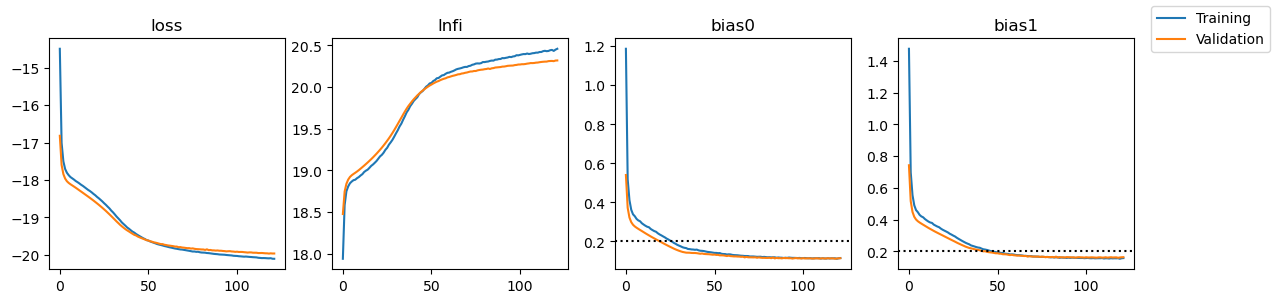

In [33]:
vecs = get_vecs(directory_path)
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
# all_vecs = all_vecs[:, : ,::2] + all_vecs[:, : ,1::2]
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation= 'relu'),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 400, reg = tf.constant([1., 1.5]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3),
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)

### 200 bins

In [34]:
directory_path = '/Users/karthikviswanathan/Downloads/topk_100_200'
fish = fisherAnalysis(directory_path)
fish = fisherAnalysisMOPED(directory_path)

log FI =  21.12
FM =  [132340.33  35817.97  35817.97  20963.8 ]
Fractional bias =  [219.33 311.89]
Constraints =  [0.00374916 0.00941987]
log FI =  20.18
FM =  [83932.92 23023.04 23023.04 13210.59]
Fractional bias =  [0.29 0.4 ]
Constraints =  [0.00477769 0.01204268]


#### IMNN

log FI =  20.47
FM =  [94530.66 26330.87 26330.87 15505.71]
Fractional bias =  [0.11 0.16]
Constraints =  [0.00448033 0.01106244]


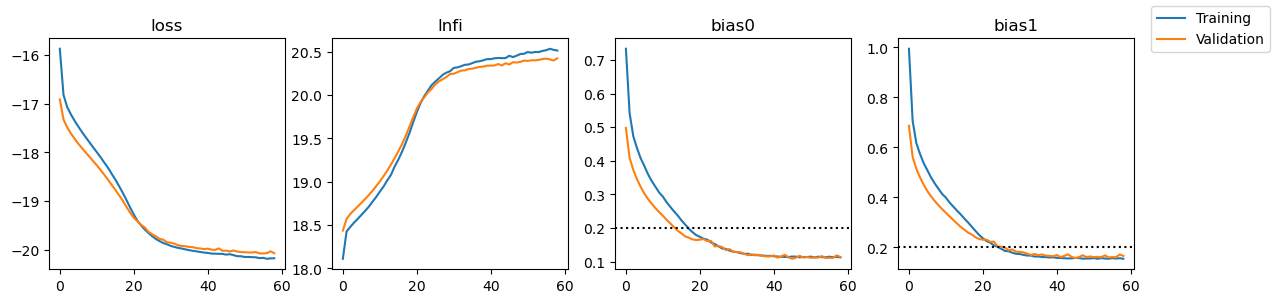

In [35]:
vecs = get_vecs(directory_path)
fid_arr, der_arr = vecs[0], vecs[1:]
all_vecs = np.stack([fid_arr[:7500], *der_arr])
# all_vecs = all_vecs[:, : ,::2] + all_vecs[:, : ,1::2]
delta_theta = np.array([0.02, 0.03])
comp = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation= 'relu'),
    tf.keras.layers.Dense(2)])
imnn_layer = IMNNLayer(comp, verbose = 0, epochs = 400, reg = tf.constant([1., 1.5]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 3, restore_best_weights = True)],\
                       optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3),
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
plotLearningGraphs(comp.history.history)
 

# Unsubsampled

In [5]:
importlib.reload(topofisher.fisher.Fisher)
from topofisher.fisher.Fisher import fisherFromVecs, fisherMOPED

In [6]:
fid_arr = np.load('/Users/karthikviswanathan/Downloads/fid_dv.npy')
der_arr = np.load('/Users/karthikviswanathan/Downloads/cosmo_dv.npy')
delta_theta_all = np.array([0.04, 0.004, 0.02, 0.03, 0.04])  
fish = fisherFromVecs([fid_arr[0], *der_arr], delta_theta_all)
show_fm_and_bias(fish)

log FI =  50.54
FM =  [  605289.75 -1322274.2   1293547.6   1012181.94   367752.97 -1322279.8
  2914929.5  -2822451.5  -2184996.5   -806227.44  1293557.8  -2822456.2
  2819689.5   2214059.8    785172.2   1012185.7  -2184992.2   2214046.2
  1800777.1    610618.6    367756.6   -806234.4    785174.     610624.56
   224032.06]
Fractional bias =  [0.19 0.46 0.03 0.07 0.36]
Constraints =  [0.03365063 0.00917508 0.00616182 0.00527166 0.06330561]


In [7]:
fish = fisherMOPED([fid_arr[0], *der_arr], delta_theta_all)
show_fm_and_bias(fish)

log FI =  45.27
FM =  [  550948.   -1202073.4   1174839.     924513.75   334065.25 -1202073.4
  2634362.   -2559456.5  -1993179.    -730852.9   1174839.1  -2559456.5
  2553982.    2018435.4    711335.25   924513.8  -1993179.2   2018435.2
  1651560.8    556418.44   334065.25  -730852.8    711335.2    556418.5
   202909.44]
Fractional bias =  [0.3  0.46 0.23 0.18 0.44]
Constraints =  [0.08368098 0.06853569 0.00978153 0.00841495 0.3533728 ]


### $\Omega_m$ and $\sigma_8$ 

In [23]:
from topofisher.fisher.Fisher import fisherMOPED, fisherFromVecs

In [21]:
fid_arr = np.load('/Users/karthikviswanathan/Downloads/fid_dv.npy')
der_arr = np.load('/Users/karthikviswanathan/Downloads/cosmo_dv.npy')
fish = fisherMOPED([fid_arr[0], *der_arr[4:8]], np.array([0.02, 0.03]))
show_fm_and_bias(fish)

log FI =  25.69
FM =  [2555376.8 2019606.5 2019606.2 1652462.1]
Fractional bias =  [0. 0.]
Constraints =  [0.00338927 0.00421471]


In [24]:
fid_arr = np.load('/Users/karthikviswanathan/Downloads/fid_dv.npy')
der_arr = np.load('/Users/karthikviswanathan/Downloads/cosmo_dv.npy')
fish = fisherFromVecs([fid_arr[0], *der_arr[4:8]], np.array([0.02, 0.03]))
show_fm_and_bias(fish)

log FI =  25.97
FM =  [2925456.2 2297083.2 2297075.5 1868284.5]
Fractional bias =  [0. 0.]
Constraints =  [0.00314397 0.00393417]


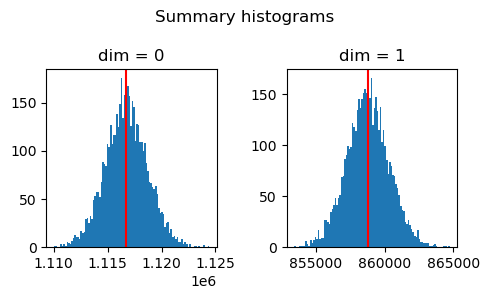

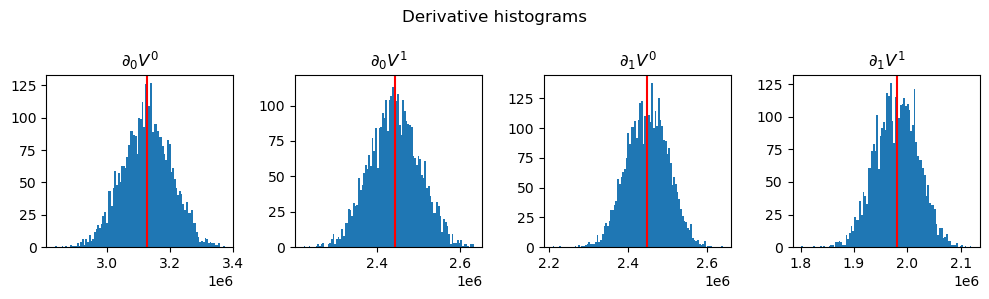

In [311]:
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence
plotSummaryDerivativeHists(fish)

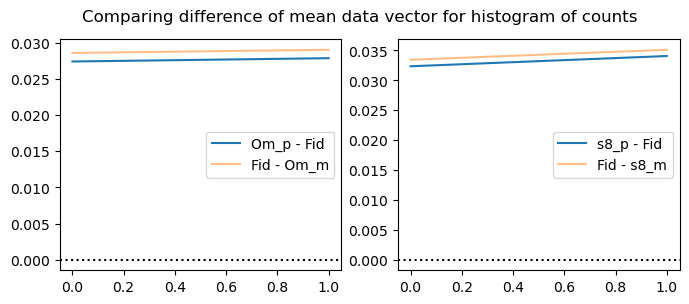

In [312]:
zz = np.array([np.array(item).mean(axis = 0) for item in fish.summaries])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                             figsize=(3 * ncols + 2 , 3))
axes[0].plot((zz[2] - zz[0])/zz[0], label = "Om_p - Fid")
axes[0].plot((zz[0] - zz[1])/zz[0], label = "Fid - Om_m", alpha = 0.5)
axes[0].axhline(0, c = 'black', linestyle = 'dotted')
axes[0].legend()

axes[1].plot((zz[4] - zz[0])/zz[0], label = "s8_p - Fid")
axes[1].plot((zz[0] - zz[3])/zz[0], label = "Fid - s8_m", alpha = 0.5)

axes[1].axhline(0, c = 'black', linestyle = 'dotted')
axes[1].legend()

fig.suptitle("Comparing difference of mean data vector for histogram of counts")
plt.show()

## First 2 parameters

In [ ]:
 ['ns_m/', 'ns_p/', 'Ob2_m/', 'Ob2_p/', 'Om_m/', 'Om_p/', 's8_m/', 's8_p/', 'h_m/', 'h_p/']

In [32]:
fid_arr[0].shape

(10000, 360)

In [49]:
findForecasts(np.array([0, 1, 2, 3, 4]))
print("\n")
findForecasts(np.array([0, 1, 2, 3, 4]), "compressed")

log FI =  50.73
FM =  [  627987.4  -1371862.9   1342086.6   1050140.1    381545.47 -1371843.5
  3024207.2  -2928310.8  -2266903.8   -836454.56  1342061.5  -2928300.2
  2925473.5   2297080.5    814615.4   1050128.8  -2266907.8   2297089.8
  1868284.1    633512.3    381547.38  -836470.06   814635.7    633523.06
   232434.05]
Fractional bias =  [0.19 0.46 0.03 0.07 0.36]
Constraints =  [0.03305993 0.00901079 0.00604934 0.00517515 0.06221631]


log FI =  45.27
FM =  [  551610.2  -1203518.1   1176250.8    925624.9    334466.75 -1203518.
  2637528.   -2562532.2  -1995574.4   -731731.1   1176250.8  -2562532.5
  2557050.8   2020860.6    712190.     925625.06 -1995574.5   2020861.
  1653545.6    557087.2    334466.78  -731731.2    712190.06   557087.2
   203153.28]
Fractional bias =  [0.3  0.46 0.23 0.18 0.44]
Constraints =  [0.08367601 0.06852406 0.00977711 0.00841043 0.35334623]


In [ ]:
def findForecasts(inds, mode = "uncompressed"): 
    new_inds = np.stack([2*inds, 2*inds + 1], axis = 1)
    der_vecs = der_arr[new_inds.flatten()]
    delta_theta = delta_theta_all[inds]
    if mode == "uncompressed" : fish = fisherFromVecs([fid_arr[0], *der_vecs], delta_theta)
    else : fish = fisherMOPED([fid_arr[0], *der_vecs], delta_theta)
    show_fm_and_bias(fish)
    
findForecasts(np.array([0, 1, 2, 3, 4]))
findForecasts(np.array([0, 1, 2, 3, 4]), "compressed")

In [47]:
print("\nUncompressed")
findForecasts(np.array([0, 2, 3, 4]))

print("\ncompressed")
findForecasts(np.array([0, 2, 3, 4]), "compressed")


Uncompressed
log FI =  41.31
FM =  [ 627987.4  1342086.6  1050140.1   381548.2  1342061.5  2925473.5
 2297080.5   814622.2  1050128.8  2297089.8  1868284.1   633516.56
  381547.38  814635.7   633523.06  232435.8 ]
Fractional bias =  [0.18 0.03 0.07 0.18]
Constraints =  [0.03299784 0.00594548 0.00501254 0.05126189]

compressed
log FI =  39.79
FM =  [ 551480.06 1175991.2   925330.56  334346.72 1175991.1  2556535.8
 2020273.8   711951.6   925330.4  2020273.6  1652878.2   556815.56
  334346.66  711951.5   556815.56  203042.22]
Fractional bias =  [0.01 0.   0.   0.01]
Constraints =  [0.05622246 0.00686738 0.00668194 0.08803947]


In [46]:
findForecasts(np.array([0, 1, 4]))
findForecasts(np.array([0, 1, 4]), "compressed")

log FI =  29.26
FM =  [  627990.25 -1371864.8    381545.47 -1371847.6   3024213.    -836454.56
   381548.38  -836471.1    232434.05]
Fractional bias =  [0.18 0.47 0.39]
Constraints =  [0.0252847  0.00872596 0.05805589]
log FI =  24.51
FM =  [  550785.44 -1202638.1    334063.12 -1202638.4   2636335.8   -731242.4
   334063.16  -731242.3    202942.06]
Fractional bias =  [0.21 0.25 0.24]
Constraints =  [0.08368129 0.06385263 0.36048794]


In [41]:
findForecasts(np.array([0, 1, 2, 3, 4]), "uncompressed")
findForecasts(np.array([0, 1, 2, 3, 4]), "compressed")

log FI =  50.73
FM =  [  627987.4  -1371862.9   1342086.6   1050140.1    381545.47 -1371843.5
  3024207.2  -2928310.8  -2266903.8   -836454.56  1342061.5  -2928300.2
  2925473.5   2297080.5    814615.4   1050128.8  -2266907.8   2297089.8
  1868284.1    633512.3    381547.38  -836470.06   814635.7    633523.06
   232434.05]
Fractional bias =  [0.19 0.46 0.03 0.07 0.36]
Constraints =  [0.03305993 0.00901079 0.00604934 0.00517515 0.06221631]
log FI =  45.27
FM =  [  551610.2  -1203518.1   1176250.8    925624.9    334466.75 -1203518.
  2637528.   -2562532.2  -1995574.4   -731731.1   1176250.8  -2562532.5
  2557050.8   2020860.6    712190.     925625.06 -1995574.5   2020861.
  1653545.6    557087.2    334466.78  -731731.2    712190.06   557087.2
   203153.28]
Fractional bias =  [0.3  0.46 0.23 0.18 0.44]
Constraints =  [0.08367601 0.06852406 0.00977711 0.00841043 0.35334623]


In [2]:
fid_arr = np.load('/Users/karthikviswanathan/Downloads/fid_dv.npy')
der_arr = np.load('/Users/karthikviswanathan/Downloads/cosmo_dv.npy')
delta_theta_all = np.array([0.04, 0.004, 0.02, 0.03, 0.04])  
fish = fisherFromVecs([fid_arr[0], *der_arr], delta_theta_all)
show_fm_and_bias(fish)

log FI =  50.73
FM =  [  627987.4  -1371862.9   1342086.6   1050140.1    381545.47 -1371843.5
  3024207.2  -2928310.8  -2266903.8   -836454.56  1342061.5  -2928300.2
  2925473.5   2297080.5    814615.4   1050128.8  -2266907.8   2297089.8
  1868284.1    633512.3    381547.38  -836470.06   814635.7    633523.06
   232434.05]
Fractional bias =  [0.19 0.46 0.03 0.07 0.36]
Constraints =  [0.03305993 0.00901079 0.00604934 0.00517515 0.06221631]


In [8]:
fish = fisherMOPED([fid_arr[0], *der_arr], delta_theta_all)
show_fm_and_bias(fish)

log FI =  45.27
FM =  [  551610.2  -1203518.1   1176250.8    925624.9    334466.75 -1203518.
  2637528.   -2562532.2  -1995574.4   -731731.1   1176250.8  -2562532.5
  2557050.8   2020860.6    712190.     925625.06 -1995574.5   2020861.
  1653545.6    557087.2    334466.78  -731731.2    712190.06   557087.2
   203153.28]
Fractional bias =  [0.3  0.46 0.23 0.18 0.44]
Constraints =  [0.08367601 0.06852406 0.00977711 0.00841043 0.35334623]


In [7]:
fid_arr = np.load('/Users/karthikviswanathan/Downloads/fid_dv.npy')
der_arr = np.load('/Users/karthikviswanathan/Downloads/cosmo_dv.npy')
param_list_new =  ['ns', 'Ob2', 'Om', 's8', 'h']
for idx in range(5) :
    print("\nParam = ", param_list_new[idx])
    fish = fisherMOPED([fid_arr[0], *der_arr[2*idx:2*idx + 2]], np.array(delta_theta_all[idx:idx + 1]))
    show_fm_and_bias(fish)


Param =  ns
log FI =  13.22
FM =  [550251.6]
Fractional bias =  [0.]
Constraints =  [0.00134809]

Param =  Ob2
log FI =  14.78
FM =  [2623497.]
Fractional bias =  [0.]
Constraints =  [0.00061739]

Param =  Om
log FI =  14.75
FM =  [2549164.5]
Fractional bias =  [0.]
Constraints =  [0.00062633]

Param =  s8
log FI =  14.32
FM =  [1648132.5]
Fractional bias =  [0.]
Constraints =  [0.00077894]

Param =  h
log FI =  12.22
FM =  [202424.69]
Fractional bias =  [0.]
Constraints =  [0.00222264]


### All params

In [325]:
fid_arr = np.load('/Users/karthikviswanathan/Downloads/fid_dv.npy')
der_arr = np.load('/Users/karthikviswanathan/Downloads/cosmo_dv.npy')
fish = fisherFromVecs([fid_arr[0], *der_arr], np.array([0.04, 0.004, 0.02, 0.03, ]))
show_fm_and_bias(fish) 

log FI =  45.17
FM =  [  627987.4 -1371862.9  1342086.6  1050140.1 -1371843.5  3024207.2
 -2928310.8 -2266903.8  1342061.5 -2928300.2  2925473.5  2297080.5
  1050128.8 -2266907.8  2297089.8  1868284.1]
Fractional bias =  [1703.83 2165.83  324.65  751.54]
Constraints =  [0.01871001 0.00742486 0.0059449  0.00485418]


In [296]:
def writeToFile(lis, fileName):
    g = open(fileName, "wb")
    pickle.dump(lis, g)
    g.close()
writeToFile(fish.summaries, 'compressed_summaries.pkl')

In [3]:
fid_arr = np.load('/Users/karthikviswanathan/Downloads/fid_dv.npy')
der_arr = np.load('/Users/karthikviswanathan/Downloads/cosmo_dv.npy')
delta_theta_all = np.array([0.04, 0.004, 0.02, 0.03, 0.04]) 

In [6]:
import topofisher
importlib.reload(topofisher.fisher.Fisher)
importlib.reload(topofisher.fisher.imnn)


<module 'topofisher.fisher.imnn' from '/Users/karthikviswanathan/Desktop/TDA/codes/fisherPH/versions/TopoFisher/topofisher/fisher/imnn.py'>

In [17]:
# all_vecs = np.stack([fid_arr[0][:7500], *der_arr])
# delta_theta = np.array([0.04, 0.004, 0.02, 0.03, 0.04])
all_vecs = [fid_arr[0][:7500], *der_arr]
delta_theta = delta_theta_all
comp = tf.keras.Sequential([
    # tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dense(50, activation= 'relu'),
    tf.keras.layers.Dense(len(delta_theta))])
imnn_layer = IMNNLayer(comp, verbose = 1, epochs = 400, reg = tf.constant([1.]),\
                       callbacks = [tf.keras.callbacks.EarlyStopping(
                                patience = 400, restore_best_weights = True)],\
                       optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3),
                       data_splits = [0.4, 0.2, 0.4], show_bias = True, show_fi = True, batch_size = 1024)
fish = imnn_layer.computeFisher(all_vecs, delta_theta)
show_fm_and_bias(fish)
# plotLearningGraphs(comp.history.history)

Epoch 1/400
3/3 [==============================] - 36s 5s/step - loss: 163.1125 - lnfi: 33.3460 - bias0: 41.3936 - bias1: 40.7262 - bias2: 39.0298 - bias3: 40.7121 - bias4: 41.3550 - val_loss: 49164.5352 - val_lnfi: 32.2457 - val_bias0: 15489.1611 - val_bias1: 15487.6865 - val_bias2: 15487.3828 - val_bias3: 15487.2783 - val_bias4: 15490.1309
Epoch 2/400
3/3 [==============================] - 0s 47ms/step - loss: 18.0154 - lnfi: 35.5966 - bias0: 10.2100 - bias1: 12.7875 - bias2: 10.6914 - bias3: 9.9263 - bias4: 9.3561 - val_loss: 1528.2770 - val_lnfi: 33.6822 - val_bias0: 444.6302 - val_bias1: 444.6391 - val_bias2: 444.7151 - val_bias3: 444.6648 - val_bias4: 443.6923
Epoch 3/400
3/3 [==============================] - 0s 42ms/step - loss: 176.2930 - lnfi: 36.4428 - bias0: 41.6628 - bias1: 41.1268 - bias2: 41.4179 - bias3: 41.6316 - bias4: 41.9733 - val_loss: 6283.2788 - val_lnfi: 34.1378 - val_bias0: 1989.7338 - val_bias1: 1989.6892 - val_bias2: 1989.8167 - val_bias3: 1989.7794 - val_bia

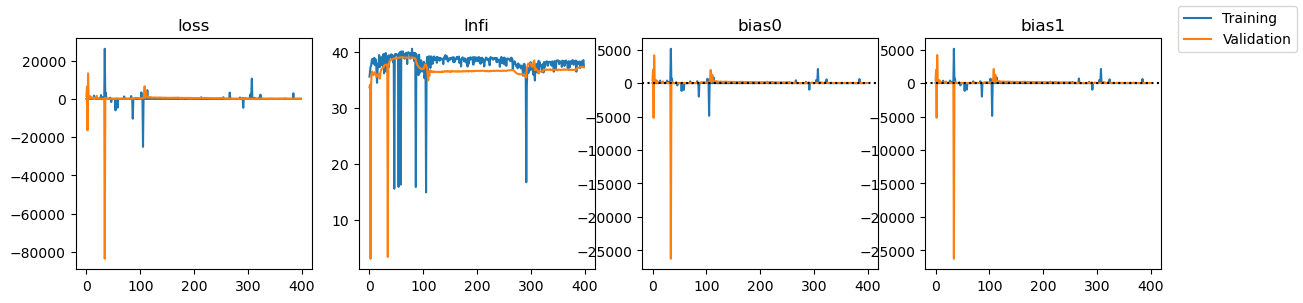

In [18]:
plotLearningGraphs(comp.history.history)